In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt
sys.path.append('..')
import covid19_inference as cov19

In [2]:
rki = cov19.data_retrieval.RKI(True)
jhu = cov19.data_retrieval.JHU(True)

INFO     [covid19_inference.data_retrieval] Using local rki data because no newer version available online.


In [3]:
#Create dates for filter
bd = datetime.datetime(2020,3,10)
ed = datetime.datetime(2020,5,9)

date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,5,9)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

# Meldedatum

INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 545.93:   7%|▋         | 14999/200000 [00:32<06:43, 458.94it/s]
Convergence achieved at 15000
INFO     [pymc3.variational.inference] Convergence achieved at 15000
Interrupted at 14,999 [7%]: Average Loss = 596.84
INFO     [pymc3.variational.i

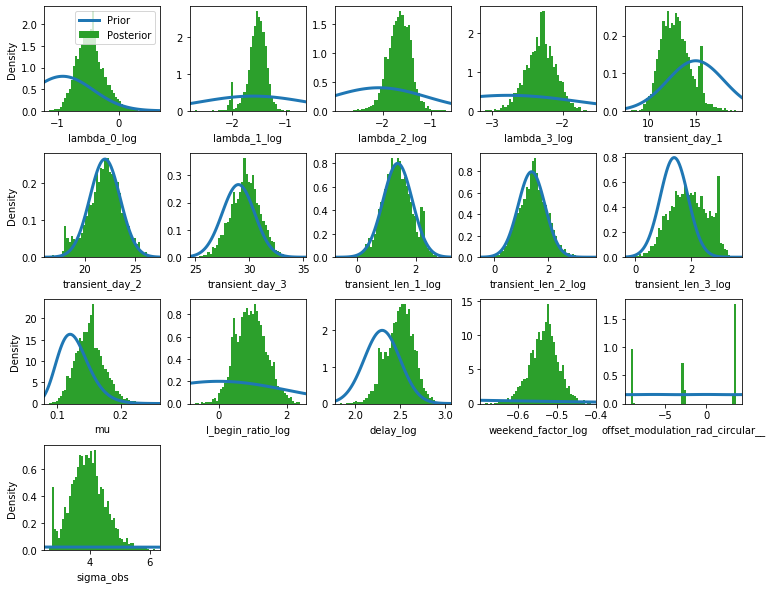

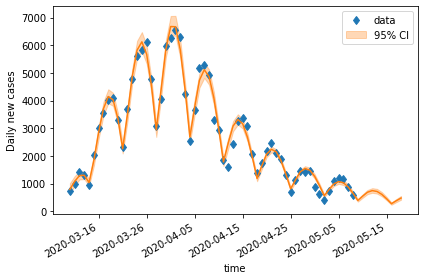

In [4]:
total_cases = rki.get_confirmed(begin_date=bd,end_date=ed)
new_cases_obs = np.diff(np.array(total_cases))

params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)
    
trace = pm.sample(model=model, tune=500, draws=1000, init='advi+adapt_diag')

trace_melde = trace
model_melde = model

varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

mpl_date_begin = mpl.dates.date2num(date_begin_data)
dates_data = mpl_date_begin + np.arange(len(new_cases_obs))
f, ax = plt.subplots()
ax.plot(dates_data, new_cases_obs, 'd', label='data')
dates_with_foracast = mpl_date_begin + np.arange(trace.new_cases.shape[1])
ax.plot(dates_with_foracast, np.median(trace.new_cases, axis=0), color='tab:orange')
ax.fill_between(dates_with_foracast, *np.percentile(trace.new_cases, q=(2.5,97.5), axis=0), alpha=0.3,
               color="tab:orange", label="95% CI")

ax.set_xlabel("time")
ax.set_ylabel("Daily new cases")
f.autofmt_xdate()

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

plt.legend();
plt.tight_layout()

# Refdatum

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 533.76:   7%|▋         | 13699/200000 [00:27<06:16, 495.09it/s]
Convergence achieved at 13700
INFO     [pymc3.variational.inference] Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 589.49
INFO     [pymc3.variational.inference] Interrupted at 13,699 [6%]: Average Loss = 589.49
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_3, transient_day_2, transient_day_1, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log, 

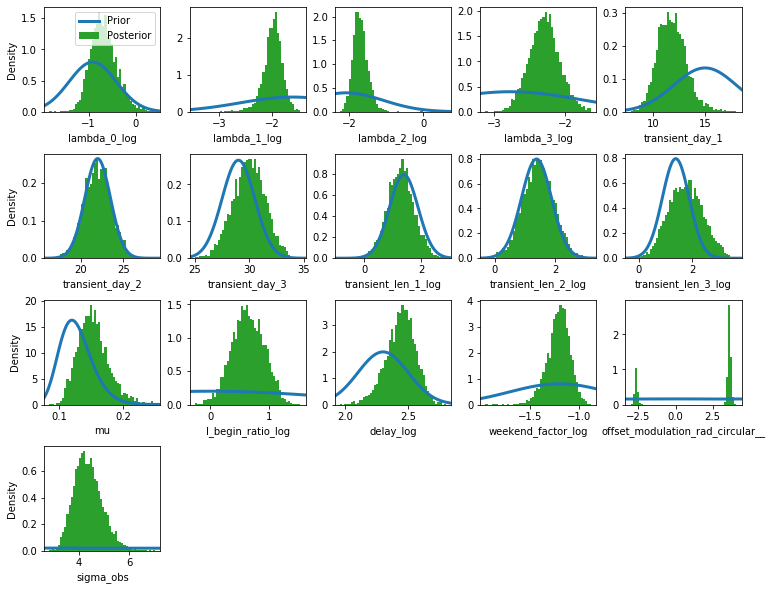

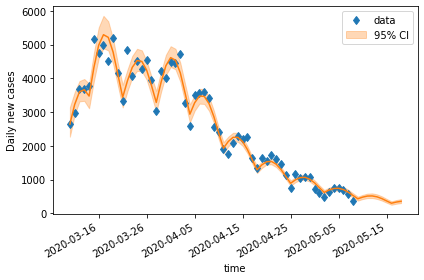

In [5]:
total_cases = rki.get_confirmed(begin_date=bd,end_date=ed, date_type='date_ref')
new_cases_obs = np.diff(np.array(total_cases))

params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)
    
trace = pm.sample(model=model, tune=500, draws=1000, init='advi+adapt_diag')

trace_ref = trace
model_ref = model

varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

mpl_date_begin = mpl.dates.date2num(date_begin_data)
dates_data = mpl_date_begin + np.arange(len(new_cases_obs))
f, ax = plt.subplots()
ax.plot(dates_data, new_cases_obs, 'd', label='data')
dates_with_foracast = mpl_date_begin + np.arange(trace.new_cases.shape[1])
ax.plot(dates_with_foracast, np.median(trace.new_cases, axis=0), color='tab:orange')
ax.fill_between(dates_with_foracast, *np.percentile(trace.new_cases, q=(2.5,97.5), axis=0), alpha=0.3,
               color="tab:orange", label="95% CI")

ax.set_xlabel("time")
ax.set_ylabel("Daily new cases")
f.autofmt_xdate()

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

plt.legend();
plt.tight_layout()

# JHU

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 599.93:   7%|▋         | 13799/200000 [00:29<06:38, 467.81it/s]
Convergence achieved at 13800
INFO     [pymc3.variational.inference] Convergence achieved at 13800
Interrupted at 13,799 [6%]: Average Loss = 672.38
INFO     [pymc3.variational.inference] Interrupted at 13,799 [6%]: Average Loss = 672.38
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log_L2_raw, weekend_factor_log_L1, sigma_weekend_factor_L2, delay_log_L2_raw, delay_log_L1, sigma_delay_L2, I_begin_ratio_log, mu, transient_len_3_log_L2_raw, transient_len_3_log_L1, sigma_transient_len_3_L2, transient_len_2_log_L2_raw, transient_len_2_log_L1, sigma_transient_len_2_L2, transient_len_1_log_L2_raw, transient_len_1_log_L1, sig

Dimension of lambda_0_log_L2_raw larger than one, skipping
Dimension of lambda_1_log_L2_raw larger than one, skipping
Dimension of lambda_2_log_L2_raw larger than one, skipping
Dimension of lambda_3_log_L2_raw larger than one, skipping
Dimension of transient_day_1_L2_raw larger than one, skipping
Dimension of transient_day_2_L2_raw larger than one, skipping
Dimension of transient_day_3_L2_raw larger than one, skipping
Dimension of transient_len_1_log_L2_raw larger than one, skipping
Dimension of transient_len_2_log_L2_raw larger than one, skipping
Dimension of transient_len_3_log_L2_raw larger than one, skipping
Dimension of I_begin_ratio_log larger than one, skipping
Dimension of delay_log_L2_raw larger than one, skipping
Dimension of weekend_factor_log_L2_raw larger than one, skipping
Dimension of sigma_obs larger than one, skipping


ValueError: Input passed into argument "'y1'"is not 1-dimensional.

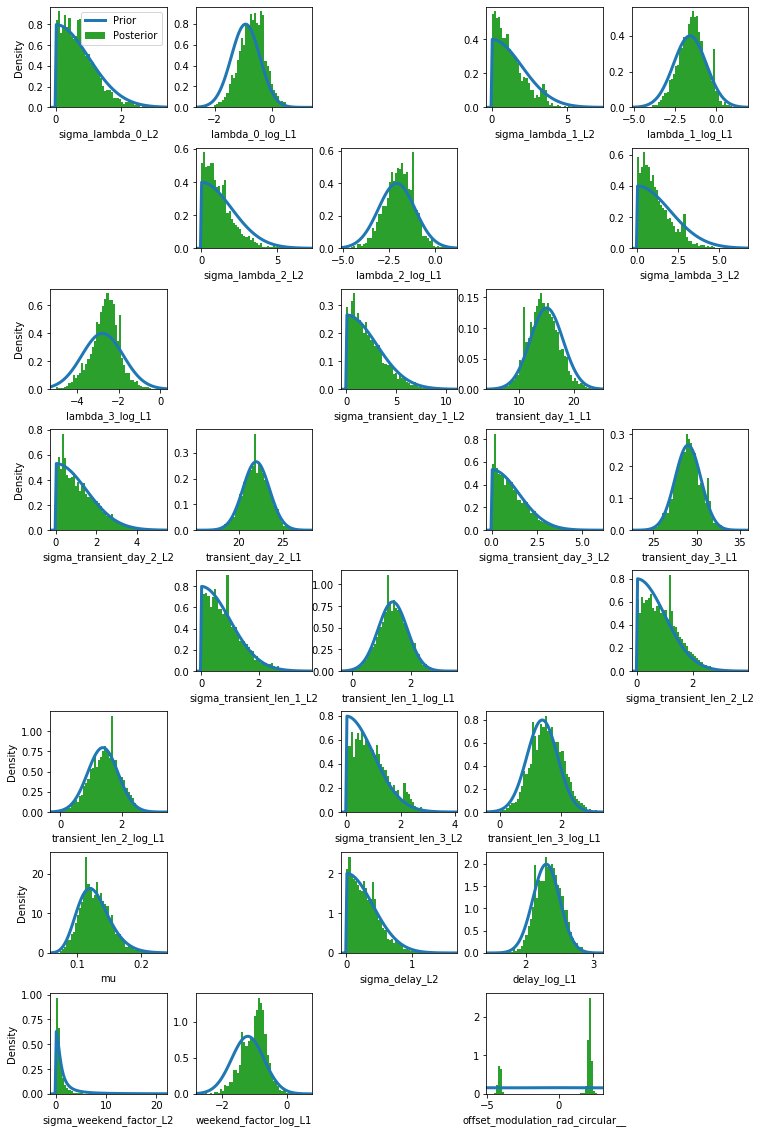

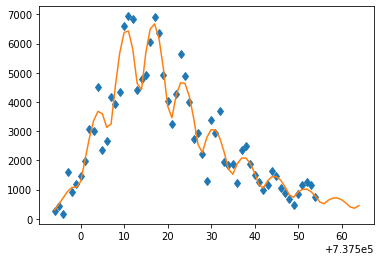

In [6]:
new_cases_obs = (jhu.get_new_confirmed(country='Germany',begin_date=bd,end_date=ed)).values

params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)
    
trace = pm.sample(model=model, tune=500, draws=1000, init='advi+adapt_diag')

trace_jhu = trace
model_jhu = model

varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

mpl_date_begin = mpl.dates.date2num(date_begin_data)
dates_data = mpl_date_begin + np.arange(len(new_cases_obs))
f, ax = plt.subplots()
ax.plot(dates_data, new_cases_obs, 'd', label='data')
dates_with_foracast = mpl_date_begin + np.arange(trace.new_cases.shape[1])
ax.plot(dates_with_foracast, np.median(trace.new_cases, axis=0), color='tab:orange')
ax.fill_between(dates_with_foracast, *np.percentile(trace.new_cases, q=(2.5,97.5), axis=0), alpha=0.3,
               color="tab:orange", label="95% CI")

ax.set_xlabel("time")
ax.set_ylabel("Daily new cases")
f.autofmt_xdate()

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))

plt.legend();
plt.tight_layout()

In [7]:
lambda_0 = [np.exp(np.median(trace_melde['lambda_0_log'])),np.exp(np.median(trace_ref['lambda_0_log']))]
lambda_1 = [np.exp(np.median(trace_melde['lambda_1_log'])),np.exp(np.median(trace_ref['lambda_1_log']))]
lambda_2 = [np.exp(np.median(trace_melde['lambda_2_log'])),np.exp(np.median(trace_ref['lambda_2_log']))]
mu = [np.median(trace_melde['mu']), np.median(trace_ref['mu'])]

print("Parameter: [Meldedatum, Refdatum]")
print("Lambda_0: ",lambda_0)
print("Lambda_1: ",lambda_1)
print("Lambda_2: ",lambda_2)
print("mu:       ",mu)

Parameter: [Meldedatum, Refdatum]
Lambda_0:  [0.6263720259167639, 0.4952788883504954]
Lambda_1:  [0.21718730486756357, 0.13921317041694017]
Lambda_2:  [0.19295241337175553, 0.1800411912410082]
mu:        [0.15119721084942003, 0.15132111773235923]
